# About
    
This file downloads data from ACLED, FSNAU (prices + EW-EA dashboard), and the public PRMN and stores it in `data/raw/`.<br>
The full PRMN is compiled on my local computer and manually updated.<br>

Then, this file compiles the raw data into standardized datasets and stores them in `data/clean`.<br>
It also plots missing values. <br>

In order to run this file each month, you must:  
1. Update the dates in the "PARAMETERS TO SET" section
2. Upload the new PRMN data from the desktop

**Data overview:**

Data type | Source | Notes
---|---|---
Conflict data | [ACLED](https://www.acleddata.com/wp-content/uploads/dlm_uploads/2017/10/API-User-Guide-11.pdf) |
Market prices | [FSNAU](http://www.fsnau.org/ids/index.php) | Helpful: https://stockrt.github.io/p/emulating-a-browser-in-python-with-mechanize/
Environment and health | [EW-EA dashboard](http://dashboard.fsnau.org/) | Rainfall, NDVI, river levels, cholera cases
Historical displacement | [UNHCR PRMN](https://unhcr.github.io/dataviz-somalia-prmn/index.html) | data on arrivals' previous, current, and future regions
Distances | imputed manually | data on geographic distance

ToDo:

- [ ] Could add other prices in FSNAU   
- [ ] Could dig into ACLED conflict types <- particularly the conflict actor   
- [ ] Could include reasons leaving from PRMN   
- [ ] Bring in FutureRegion   
- [ ] Confirm that distances are in meters  

In [1]:
import missingno as msno
import networkx as nx
import urllib.request, json 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib.request, json
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import geopandas as gp
import mechanize
import time
from io import StringIO
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
import http.cookiejar as cookielib
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database
%matplotlib inline

import jetson_configs as jcfg

# These scripts download the raw data
from src.get_data.get_acled       import *
from src.get_data.get_ew_ea       import *
from src.get_data.get_fsnau       import *
from src.get_data.get_distances   import *
from src.get_data.get_gis         import *
from src.get_data.get_public_prmn import *

# These scripts compile and standardize the data
from src.compile_data.compile_ew_ea       import *
from src.compile_data.compile_fsnau       import *
from src.compile_data.compile_distances   import *
from src.compile_data.compile_acled       import *
from src.compile_data.compile_public_prmn import *
from src.compile_data.compile_private_prmn import *
from src.compile_data.compile_gis import *

from src.compile_data.compile_master import *

# Configure connection

In [2]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [3]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

## PARAMETERS TO SET

In [4]:
data_dir = 'data/clean'

In [5]:
min_date = jcfg.first_month
max_date = jcfg.current_month

# Credentials for ACLED site
acled_user = jcfg.acled_user
acled_pass = jcfg.acled_pass

# Credentials for FSNAU site
fsnau_user = jcfg.fsnau_user
fsnau_pass = jcfg.fsnau_pass

# Credentials for early-warning early-action dashboard
ew_ea_user = jcfg.ew_ea_user
ew_ea_pass = jcfg.ew_ea_pass

# Whether to use public or private prmn
use_public_prmn = jcfg.use_public_prmn

## Get all the data
Pull the data from the web.

In [6]:
# Data that needs to be downloaded only once
get_gis_all(      redownload=False)
get_distances_all(redownload=False)

In [7]:
# Data that needs to be downloaded monthly
# Careful: need to redownload last date if downloaded mid-month !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
get_acled_all(       min_date, max_date, acled_user, acled_pass, redownload=False)
get_fsnau_all(       min_date, max_date, fsnau_user, fsnau_pass, redownload=False)
get_ew_ea_all(       min_date, max_date, ew_ea_user, ew_ea_pass, redownload=False)
get_ew_ea_rivers_all(min_date, max_date, ew_ea_user, ew_ea_pass, redownload=False)
get_public_prmn()

The following files were downloaded: []
The following files were downloaded: []
The following files were downloaded: []
The following files were downloaded: []


## Clean all the data
Clean the data and structure into datasets.

In [8]:
compile_gis(         sql_engine=engine)
compile_distances(   sql_engine=engine)
compile_acled(       sql_engine=engine)
compile_fsnau(       sql_engine=engine)
compile_ew_ea(       sql_engine=engine)
compile_ew_ea_rivers(sql_engine=engine)
compile_public_prmn( sql_engine=engine)
compile_private_prmn(sql_engine=engine) # Must come AFTER public prmn

compile_master(sql_engine=engine)

# Private PRMN is compiled locally and copied over
#'Security Incidents', 'Fatalities', 'Total Alarms'

C:\Users\katherine\.conda\envs\py36\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
C:\Users\katherine\.conda\envs\py36\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


2015-01-01
2020-12-01
2015-01-01
2020-12-01
2016-07-01
2018-12-01
2015-01-01
2020-12-01
2016-01-01
2020-12-01


## Quick inspection

In [9]:
acled        = pd.read_sql(f"SELECT * FROM acled_admin1",         con=engine, index_col=['region', 'date'])
prmn         = pd.read_sql(f"SELECT * FROM prmn_admin1",          con=engine, index_col=['region', 'date'])
fsnau        = pd.read_sql(f"SELECT * FROM fsnau_admin1",         con=engine, index_col=['region', 'date'])
ew_ea        = pd.read_sql(f"SELECT * FROM ew_ea_admin1",         con=engine, index_col=['region', 'date'])
distances    = pd.read_sql(f"SELECT * FROM distances_admin1",     con=engine, index_col=['region'])
ew_ea_rivers = pd.read_sql(f"SELECT * FROM monthly_ew_ea_rivers", con=engine, index_col=['date'])

### EW-EA

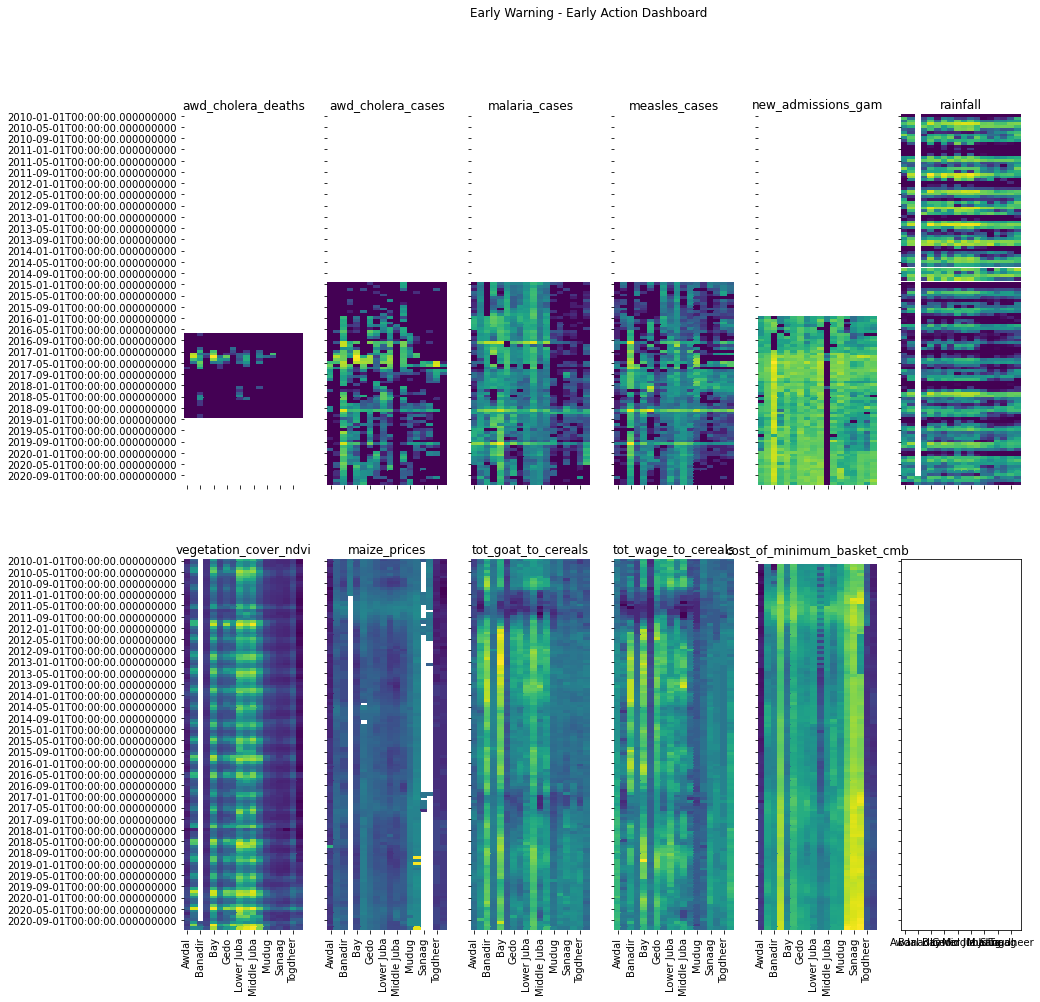

In [10]:
fig, ax = plt.subplots(2,6, figsize=[15,15], sharey=True, sharex=True)

n=0
for c in ew_ea.columns:
    
    i = n//6
    j = n%6
    sns.heatmap(np.log(1+ew_ea[c].unstack(level='region')), cbar=None, ax=ax[i][j], cmap='viridis')
    
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
    ax[i][j].set_title(c)
    
    n+=1
    
fig.suptitle("Early Warning - Early Action Dashboard")
plt.savefig("figures/missing/ew_ea.png", dpi=100, bbox_inches="tight")

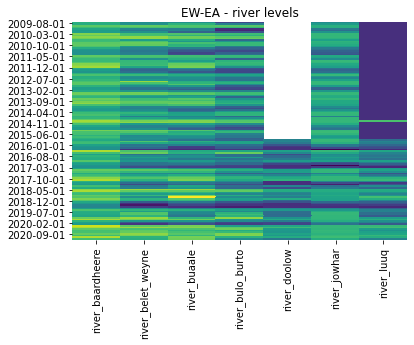

In [11]:
fig, ax = plt.subplots(1,1)

sns.heatmap(np.log(1+ew_ea_rivers), cbar=None, ax=ax, cmap='viridis')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("EW-EA - river levels")
plt.savefig("figures/missing/ew_ea_rivers.png", dpi=100, bbox_inches="tight")

### FSNAU

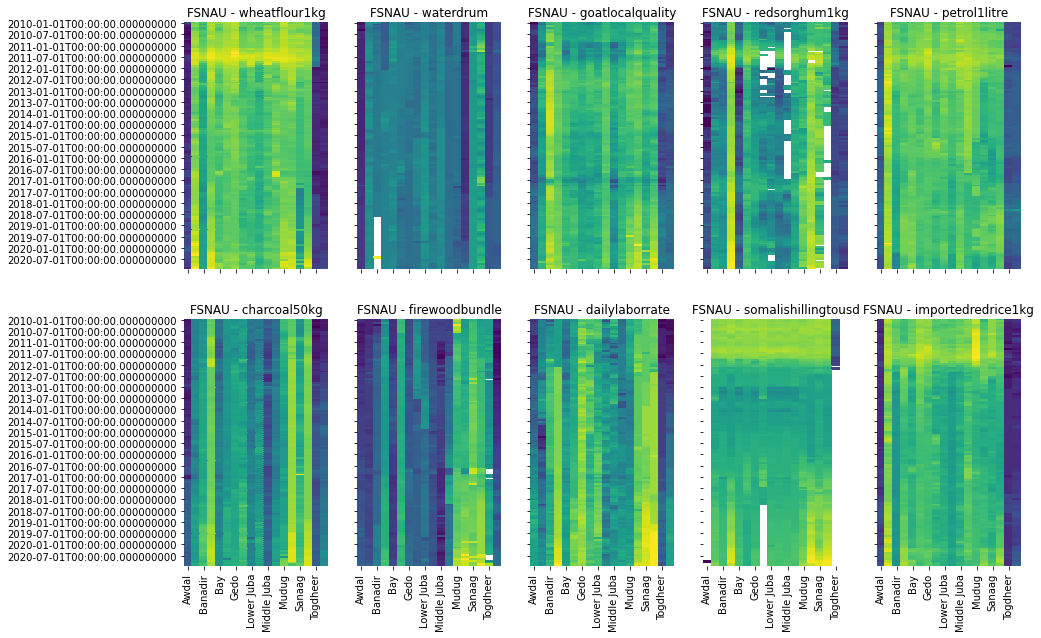

In [12]:
fig, ax = plt.subplots(2,5, figsize=[15,10], sharey=True, sharex=True)

n=0
for c in fsnau.columns:
    

    i = n//5
    j = n%5

    sns.heatmap(np.log(1+fsnau[c].unstack(level='region')), cbar=None, ax=ax[i][j], cmap='viridis')
    
    ax[i][j].set_title("FSNAU - " + c)
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
    
    n+=1

plt.savefig("figures/missing/fsnau.png", dpi=100, bbox_inches="tight")

### ACLED

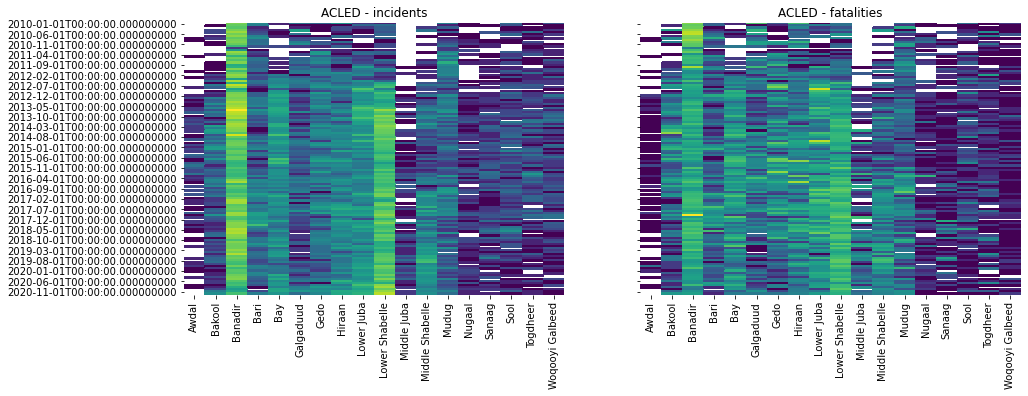

In [13]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

n=0
for c in acled.columns:
    

    sns.heatmap(np.log(1+acled[c].unstack(level='region')), cbar=None, ax=ax[n], cmap='viridis')
    
    ax[n].set_xlabel("")
    ax[n].set_ylabel("")
    ax[n].set_title("ACLED - " + c)
    
    n+=1

plt.savefig("figures/missing/acled.png", dpi=100, bbox_inches="tight")

### PRMN

In [14]:
# Add a column with ratio of arrivals to departures 
prmn['ratio'] = (1+prmn.arrivals)/(1+prmn.departures)

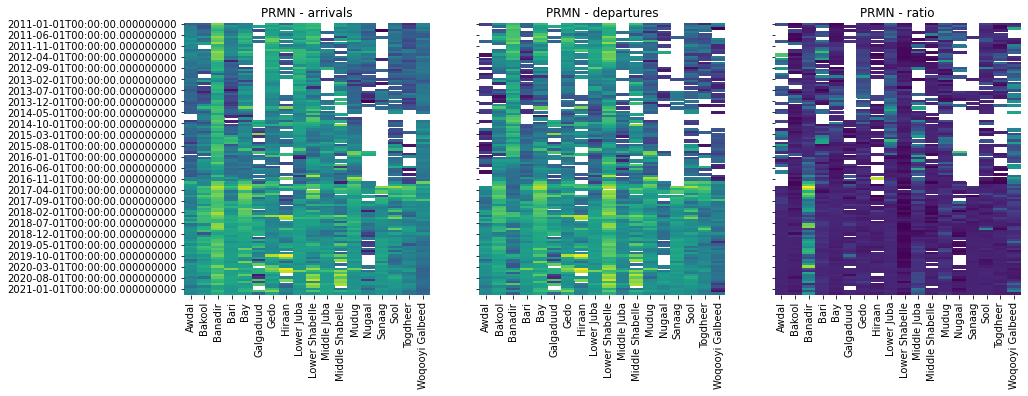

In [15]:
fig, ax = plt.subplots(1,3, figsize=[15,5], sharey=True)

n=0
for c in prmn.columns:
    
    sns.heatmap(np.log(1+prmn[c].unstack(level='region')), cbar=None, 
                ax=ax[n], cmap='viridis')
    
    ax[n].set_xlabel("")
    ax[n].set_ylabel("")
    ax[n].set_title("PRMN - " + c)
    
    n+=1

plt.savefig("figures/missing/prmn.png", dpi=100, bbox_inches="tight")